# MSADS509 Final Project Modeling

In [82]:
import datetime
import random
import time
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os
import re
import spacy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics import accuracy_score, classification_report

from scipy.sparse import hstack

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from pandas import json_normalize

nlp = spacy.load('en_core_web_sm')

from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /Users/kevinbaum/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kevinbaum/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Load data from Data folder

In [83]:
# make sure your directory is the same one that was used to store the cleaned dataframe
df = pd.read_csv('Data/cleaned.csv')

def clean_tokens(tokens):
    return [token.strip("[]'") for token in tokens.split(', ')]

df['tokens'] = df['tokens'].apply(clean_tokens)
df

,source,url,content,tokens
0,cnn,https://www.cnn.com/2024/02/12/politics/cq-bro...,Chairman of the Joint Chiefs of Staff Gen. CQ ...,"[chairman, joint, chiefs, staff, gen, cq, brow..."
1,cnn,https://www.cnn.com/2024/02/12/politics/trump-...,Trump has endorsed North Carolina Republican P...,"[trump, endorsed, north, carolina, republican,..."
2,cnn,https://www.cnn.com/2024/02/12/politics/senate...,The Senate is inching closer to final passage ...,"[senate, inching, closer, final, passage, 953,..."
3,cnn,https://www.cnn.com/2024/02/12/politics/bidens...,Biden and King Abdullah II of Jordan met Monda...,"[biden, king, abdullah, ii, jordan, met, monda..."
4,cnn,https://www.cnn.com/2024/02/12/politics/trump-...,Trump on Monday asked the SupremeCourt to step...,"[trump, monday, asked, supremecourt, step, cha..."
...,...,...,...,...
348,foxnews,https://www.foxnews.com/politics/fox-news-poli...,Welcome to Fox News’ Politics newsletter with ...,"[welcome, news’, politics, newsletter, latest,..."
349,foxnews,https://www.foxnews.com/politics/fox-news-poli...,Welcome to Fox News’ Politics newsletter with ...,"[welcome, news’, politics, newsletter, latest,..."
350,foxnews,https://www.foxnews.com/politics/fox-news-poli...,Welcome to Fox News’ Politics newsletter with ...,"[welcome, news’, politics, newsletter, latest,..."
351,foxnews,https://www.foxnews.com/politics/democrats-win...,Dems flipping NY House seat threatens GOP majo...,"[dems, flipping, ny, house, seat, threatens, g..."


## EDA for tokens

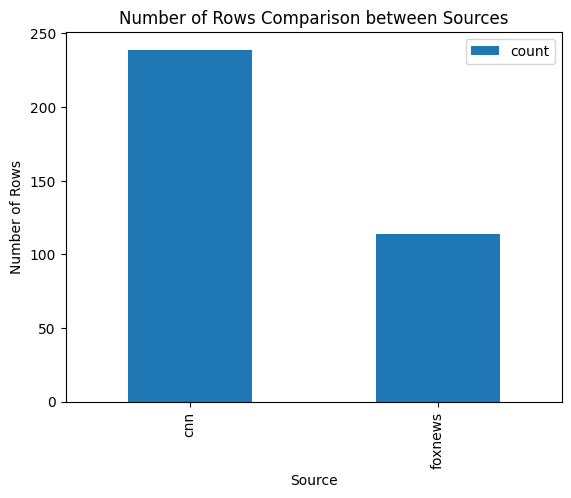

In [84]:
# Count the number of rows for each source
source_counts = df['source'].value_counts()

source_counts.plot(kind='bar', legend=True)
plt.xlabel('Source')
plt.ylabel('Number of Rows')
plt.title('Number of Rows Comparison between Sources')
plt.show()

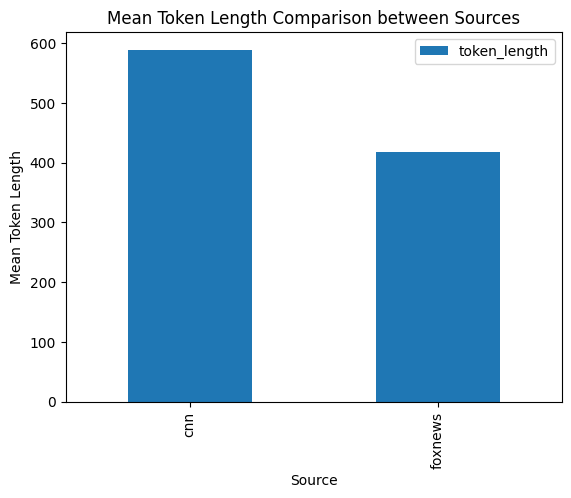

In [85]:
# the length of tokens for each article
df['token_length'] = df['tokens'].apply(lambda x: len(x))

source_token_length = df.groupby('source')['token_length'].mean()

source_token_length.plot(kind='bar', legend=True)
plt.xlabel('Source')
plt.ylabel('Mean Token Length')
plt.title('Mean Token Length Comparison between Sources')
plt.show()

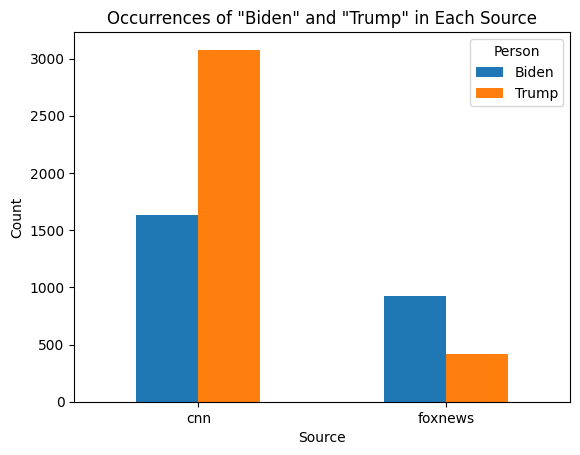

In [86]:
# count occurrences of a word in a list
def count_occurrences(tokens, word):
    return sum(1 for token in tokens if re.search(r'\b{}\b'.format(word), token, flags=re.IGNORECASE))

biden_counts = df.groupby('source')['tokens'].apply(lambda x: sum(count_occurrences(tokens, 'biden') for tokens in x))
trump_counts = df.groupby('source')['tokens'].apply(lambda x: sum(count_occurrences(tokens, 'trump') for tokens in x))

counts_df = pd.DataFrame({'Biden': biden_counts, 'Trump': trump_counts})

counts_df.plot(kind='bar')
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Occurrences of "Biden" and "Trump" in Each Source')
plt.xticks(rotation=0)
plt.legend(title='Person')
plt.show()

## WordCloud for each Source

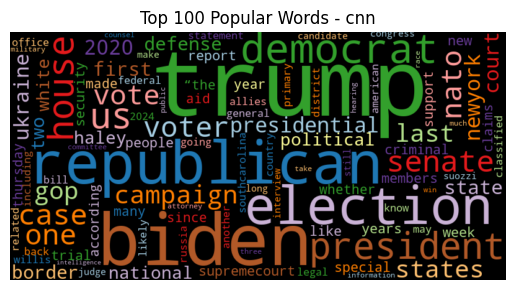

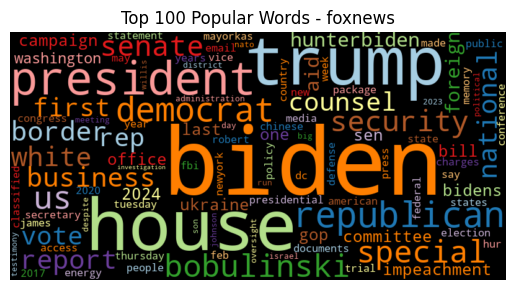

In [87]:

def wordcloud(df, title=None, max_words=100, stopwords=None):
    unique_sources = df['source'].unique()
    for source in unique_sources:
        tokens = df[df['source'] == source]['tokens']
        all_tokens = [token for sublist in tokens for token in sublist]
        counter = Counter(all_tokens)

        # Filter stop words in frequency counter
        if stopwords is not None:
            counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}

        wc = WordCloud(width=800, height=400,
                       background_color="black", colormap="Paired",
                       max_font_size=150, max_words=max_words)
        wc.generate_from_frequencies(counter)
        
        plt.title(f"{title} - {source}")
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

wordcloud(df, title="Top 100 Popular Words")


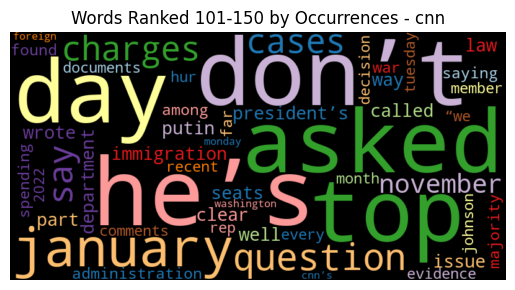

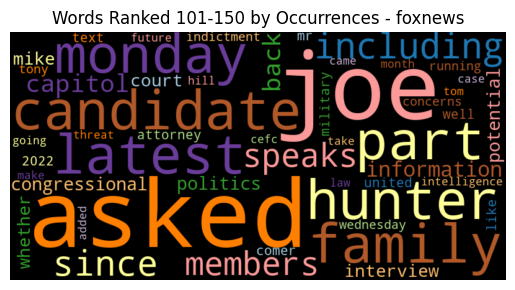

In [88]:

def wordcloud(df, title=None, max_words=200, stopwords=None):
    unique_sources = df['source'].unique()
    for source in unique_sources:
        tokens = df[df['source'] == source]['tokens']
        all_tokens = [token for sublist in tokens for token in sublist]
        counter = Counter(all_tokens)

        # Filter stop words in frequency counter
        if stopwords is not None:
            counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}

        # Sort the counter by frequency and get the words ranked from 101st to 150th
        sorted_counter = dict(counter.most_common())
        words_101_to_150 = dict(list(sorted_counter.items())[100:150])

        wc = WordCloud(width=800, height=400,
                       background_color="black", colormap="Paired",
                       max_font_size=150, max_words=max_words)
        wc.generate_from_frequencies(words_101_to_150)
        
        plt.title(f"{title} - {source}")
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

wordcloud(df, title="Words Ranked 101-150 by Occurrences")


## Modeling and Model Evaluations

## Topic Modeling

In [89]:
sw = stopwords.words("english")
punctuation = set(punctuation) # speeds up comparison
extra_sw = ['cnn', 'fox', 'news', 'said', '-', '-', '--', '—','told', 'would', 'read', 'get', 'could', 
            'also', "it's", 'think', 'time', 'even', 'former', 'party', 'i', '“i', "she's", 'says', 
            'images', 'getty', 'im', 'this', 'we', 'it', 'digital', 'the', 'that', 'story', 'doesn']
sw.extend(extra_sw)

In [90]:
# define the topic displaying function
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [91]:
# create separate dataframes for the two news sources
cnn_df = df[df['source'] == 'cnn']
fox_df = df[df['source'] == 'foxnews']

# define the function to join tokens back into a string
def join_tokens(tokens):
    return ' '.join(tokens)

# Apply the join_tokens function to the "tokens" column
cnn_df["tokens_str"] = cnn_df["tokens"].apply(join_tokens)
fox_df["tokens_str"] = fox_df["tokens"].apply(join_tokens)

In [92]:
cnn_df

,source,url,content,tokens,token_length,tokens_str
0,cnn,https://www.cnn.com/2024/02/12/politics/cq-bro...,Chairman of the Joint Chiefs of Staff Gen. CQ ...,"[chairman, joint, chiefs, staff, gen, cq, brow...",469,chairman joint chiefs staff gen cq brown monda...
1,cnn,https://www.cnn.com/2024/02/12/politics/trump-...,Trump has endorsed North Carolina Republican P...,"[trump, endorsed, north, carolina, republican,...",104,trump endorsed north carolina republican chair...
2,cnn,https://www.cnn.com/2024/02/12/politics/senate...,The Senate is inching closer to final passage ...,"[senate, inching, closer, final, passage, 953,...",399,senate inching closer final passage 953 billio...
3,cnn,https://www.cnn.com/2024/02/12/politics/bidens...,Biden and King Abdullah II of Jordan met Monda...,"[biden, king, abdullah, ii, jordan, met, monda...",642,biden king abdullah ii jordan met monday aimin...
4,cnn,https://www.cnn.com/2024/02/12/politics/trump-...,Trump on Monday asked the SupremeCourt to step...,"[trump, monday, asked, supremecourt, step, cha...",567,trump monday asked supremecourt step charged d...
...,...,...,...,...,...,...
328,cnn,https://www.cnn.com/2024/02/15/politics/emhoff...,Second gentleman Doug Emhoff slipped into NewY...,"[second, gentleman, doug, emhoff, slipped, new...",295,second gentleman doug emhoff slipped newyork t...
329,cnn,https://www.cnn.com/2024/02/15/politics/trump-...,Trump made his final pitch Thursday to the Sup...,"[trump, made, final, pitch, thursday, supremec...",223,trump made final pitch thursday supremecourt e...
330,cnn,https://www.cnn.com/2024/02/15/politics/white-...,The White House wrote to Attorney General Merr...,"[white, house, wrote, attorney, general, merri...",396,white house wrote attorney general merrick gar...
331,cnn,https://www.cnn.com/2024/02/15/politics/mike-t...,House Intelligence Chairman Mike Turner is fac...,"[house, intelligence, chairman, mike, turner, ...",520,house intelligence chairman mike turner facing...


In [93]:
fox_df

,source,url,content,tokens,token_length,tokens_str
47,foxnews,https://www.foxnews.com/politics/biden-takes-j...,Biden takes jab at special counsel report with...,"[biden, takes, jab, special, counsel, report, ...",473,biden takes jab special counsel report joke me...
48,foxnews,https://www.foxnews.com/politics/rfk-jr-apolog...,RFK Jr. drops surprise campaign ad during Supe...,"[rfk, jr, drops, surprise, campaign, ad, super...",323,rfk jr drops surprise campaign ad super bowl a...
49,foxnews,https://www.foxnews.com/politics/bidens-upcomi...,Biden won't take cognitive test in physical ex...,"[biden, wont, take, cognitive, test, physical,...",228,biden wont take cognitive test physical exam w...
50,foxnews,https://www.foxnews.com/politics/kamala-harris...,Marc Thiessen questions whether Biden is capab...,"[marc, thiessen, questions, whether, biden, ca...",274,marc thiessen questions whether biden capable ...
51,foxnews,https://www.foxnews.com/politics/climate-activ...,Biden export suspension on liquefied natural g...,"[biden, export, suspension, liquefied, natural...",451,biden export suspension liquefied natural gas ...
...,...,...,...,...,...,...
348,foxnews,https://www.foxnews.com/politics/fox-news-poli...,Welcome to Fox News’ Politics newsletter with ...,"[welcome, news’, politics, newsletter, latest,...",139,welcome news’ politics newsletter latest polit...
349,foxnews,https://www.foxnews.com/politics/fox-news-poli...,Welcome to Fox News’ Politics newsletter with ...,"[welcome, news’, politics, newsletter, latest,...",258,welcome news’ politics newsletter latest polit...
350,foxnews,https://www.foxnews.com/politics/fox-news-poli...,Welcome to Fox News’ Politics newsletter with ...,"[welcome, news’, politics, newsletter, latest,...",301,welcome news’ politics newsletter latest polit...
351,foxnews,https://www.foxnews.com/politics/democrats-win...,Dems flipping NY House seat threatens GOP majo...,"[dems, flipping, ny, house, seat, threatens, g...",545,dems flipping ny house seat threatens gop majo...


In [94]:
# create our count text vectorizers 
cnn_count_text_vectorizer = CountVectorizer(stop_words=list(sw), min_df=3, max_df=0.7)
cnn_count_text_vectors = cnn_count_text_vectorizer.fit_transform(cnn_df["tokens_str"])
print(cnn_count_text_vectors.shape)

fox_count_text_vectorizer = CountVectorizer(stop_words=list(sw), min_df=3, max_df=0.7)
fox_count_text_vectors = fox_count_text_vectorizer.fit_transform(fox_df["tokens_str"])
print(fox_count_text_vectors.shape)

(239, 5727)
(114, 2784)


In [95]:
# create our tf-idf text vectorizers 
cnn_tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(sw), min_df=3, max_df=0.7)
cnn_tfidf_text_vectors = cnn_tfidf_text_vectorizer.fit_transform(cnn_df['tokens_str'])
print(cnn_tfidf_text_vectors.shape)

fox_tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(sw), min_df=3, max_df=0.7)
fox_tfidf_text_vectors = fox_tfidf_text_vectorizer.fit_transform(fox_df['tokens_str'])
print(fox_tfidf_text_vectors.shape)

(239, 5727)
(114, 2784)


### Fitting a Non-Negative Matrix Factorization Model

#### 5 Topics

In [96]:
# fit our NMF models
cnn_nmf_model = NMF(n_components=5, random_state=314)
cnn_W_nmf_matrix = cnn_nmf_model.fit_transform(cnn_tfidf_text_vectors)
cnn_H_nmf_matrix = cnn_nmf_model.components_

fox_nmf_model = NMF(n_components=5, random_state=315)
fox_W_nmf_matrix = fox_nmf_model.fit_transform(fox_tfidf_text_vectors)
fox_H_nmf_matrix = fox_nmf_model.components_

In [97]:
# assertion statements to ensure the document-topic and topic-feature matrices have the intended shapes
assert cnn_W_nmf_matrix.shape == (239, 5), f"Expected shape (239, 5), but got {cnn_W_nmf_matrix.shape}"
assert cnn_H_nmf_matrix.shape == (5, 5727), f"Expected shape (5, 5753), but got {cnn_H_nmf_matrix.shape}"
assert fox_W_nmf_matrix.shape == (114, 5), f"Expected shape (114, 5), but got {fox_W_nmf_matrix.shape}"
assert fox_H_nmf_matrix.shape == (5, 2784), f"Expected shape (5, 2980), but got {fox_H_nmf_matrix.shape}"

In [98]:
display_topics(cnn_nmf_model, cnn_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  democrat (0.86)
  republican (0.72)
  voter (0.70)
  suozzi (0.69)
  election (0.65)

Topic 01
  case (1.19)
  trial (0.89)
  willis (0.83)
  court (0.82)
  supremecourt (0.79)

Topic 02
  nato (3.76)
  us (0.92)
  defense (0.82)
  alliance (0.80)
  spending (0.78)

Topic 03
  hur (1.56)
  classified (1.14)
  report (1.08)
  documents (0.91)
  counsel (0.70)

Topic 04
  ukraine (1.51)
  aid (1.10)
  bill (1.00)
  senate (0.93)
  border (0.91)


In [99]:
display_topics(fox_nmf_model, fox_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  border (0.98)
  mayorkas (0.89)
  senate (0.89)
  republican (0.87)
  aid (0.85)

Topic 01
  bobulinski (3.89)
  hunterbiden (1.85)
  business (1.10)
  2017 (0.98)
  family (0.95)

Topic 02
  special (1.05)
  counsel (1.03)
  hur (0.96)
  classified (0.96)
  memory (0.96)

Topic 03
  trump (2.63)
  nato (1.19)
  alliance (0.57)
  willis (0.53)
  putin (0.50)

Topic 04
  gov (1.32)
  harris (0.96)
  run (0.89)
  beshear (0.83)
  democrat (0.83)


In [100]:
cnn_W_nmf_matrix.sum(axis=0)/cnn_W_nmf_matrix.sum()*100.0

array([19.02773703, 22.64749193, 15.69502033, 20.99938344, 21.63036727])

In [101]:
fox_W_nmf_matrix.sum(axis=0)/fox_W_nmf_matrix.sum()*100.0

array([18.69943504, 18.49651482, 24.12475234, 23.06412008, 15.61517773])

#### 4 Topics

In [102]:
# fit our NMF models 4
cnn_nmf_model4 = NMF(n_components=4, random_state=314)
cnn_W_nmf_matrix4 = cnn_nmf_model4.fit_transform(cnn_tfidf_text_vectors)
cnn_H_nmf_matrix4 = cnn_nmf_model4.components_

fox_nmf_model4 = NMF(n_components=4, random_state=315)
fox_W_nmf_matrix4 = fox_nmf_model4.fit_transform(fox_tfidf_text_vectors)
fox_H_nmf_matrix4 = fox_nmf_model4.components_

In [103]:
display_topics(cnn_nmf_model4, cnn_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  democrat (0.85)
  republican (0.83)
  suozzi (0.65)
  voter (0.61)
  senate (0.59)

Topic 01
  case (1.16)
  trial (0.86)
  willis (0.81)
  court (0.81)
  supremecourt (0.78)

Topic 02
  nato (1.94)
  ukraine (1.16)
  us (0.83)
  russia (0.73)
  putin (0.70)

Topic 03
  hur (1.53)
  classified (1.11)
  report (1.07)
  documents (0.89)
  counsel (0.69)


In [104]:
display_topics(fox_nmf_model4, fox_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  border (0.94)
  republican (0.84)
  senate (0.83)
  mayorkas (0.83)
  aid (0.77)

Topic 01
  bobulinski (3.85)
  hunterbiden (1.84)
  business (1.09)
  2017 (0.97)
  family (0.94)

Topic 02
  special (0.98)
  hur (0.95)
  counsel (0.95)
  report (0.88)
  memory (0.86)

Topic 03
  trump (2.59)
  nato (1.13)
  alliance (0.54)
  willis (0.54)
  putin (0.47)


In [105]:
cnn_W_nmf_matrix4.sum(axis=0)/cnn_W_nmf_matrix4.sum()*100.0

array([24.93391053, 26.05850217, 26.13680193, 22.87078537])

In [106]:
fox_W_nmf_matrix4.sum(axis=0)/fox_W_nmf_matrix4.sum()*100.0

array([23.87731774, 20.40693119, 29.15706217, 26.5586889 ])

### Fitting an LSA Model

#### 5 Topics

In [107]:
# fit our LSA models
cnn_svd_model = TruncatedSVD(n_components=5, random_state=320)
cnn_W_svd_matrix = cnn_svd_model.fit_transform(cnn_tfidf_text_vectors)
cnn_H_svd_matrix = cnn_svd_model.components_

fox_svd_model = TruncatedSVD(n_components=5, random_state=321)
fox_W_svd_matrix = fox_svd_model.fit_transform(fox_tfidf_text_vectors)
fox_H_svd_matrix = fox_svd_model.components_

In [108]:
# assertion statements to ensure the document-topic and topic-feature matrices have the intended shapes
assert cnn_W_svd_matrix.shape == (239, 5), f"Expected shape (239, 5), but got {cnn_W_svd_matrix.shape}"
assert cnn_H_svd_matrix.shape == (5, 5727), f"Expected shape (5, 5753), but got {cnn_H_svd_matrix.shape}"
assert fox_W_svd_matrix.shape == (114, 5), f"Expected shape (114, 5), but got {fox_W_svd_matrix.shape}"
assert fox_H_svd_matrix.shape == (5, 2784), f"Expected shape (5, 2980), but got {fox_H_svd_matrix.shape}"

In [109]:
display_topics(cnn_svd_model, cnn_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  republican (0.43)
  election (0.40)
  democrat (0.35)
  nato (0.31)
  case (0.30)

Topic 01
  case (59.51)
  trial (44.98)
  willis (43.31)
  court (39.87)
  supremecourt (39.65)

Topic 02
  nato (10.13)
  defense (3.05)
  us (2.71)
  case (2.64)
  russia (2.52)

Topic 03
  hur (8.76)
  classified (6.48)
  report (6.21)
  documents (5.19)
  information (3.78)

Topic 04
  ukraine (4.11)
  aid (3.22)
  bill (2.93)
  senate (2.51)
  case (2.31)


In [110]:
display_topics(fox_svd_model, fox_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (0.72)
  bobulinski (0.58)
  republican (0.38)
  special (0.36)
  democrat (0.33)

Topic 01
  bobulinski (19.31)
  hunterbiden (9.04)
  business (5.01)
  2017 (4.81)
  cefc (4.59)

Topic 02
  counsel (24.74)
  hur (24.52)
  special (23.46)
  memory (22.65)
  classified (22.47)

Topic 03
  trump (166.95)
  nato (88.82)
  alliance (45.86)
  willis (41.44)
  putin (35.64)

Topic 04
  gov (7.04)
  run (5.42)
  harris (4.67)
  willis (4.59)
  beshear (4.51)


In [111]:
cnn_W_svd_matrix.sum(axis=0)/cnn_W_svd_matrix.sum()*100.0

array([94.08815765, -3.5328664 ,  5.91873364,  5.96116098, -2.43518588])

In [112]:
fox_W_svd_matrix.sum(axis=0)/fox_W_svd_matrix.sum()*100.0

array([104.75824529,  -4.06305171,   1.53755958,  -1.83574926,
        -0.39700391])

#### 4 Topics

In [113]:
# fit our LSA models 4
cnn_svd_model4 = TruncatedSVD(n_components=4, random_state=320)
cnn_W_svd_matrix4 = cnn_svd_model4.fit_transform(cnn_tfidf_text_vectors)
cnn_H_svd_matrix4 = cnn_svd_model4.components_

fox_svd_model4 = TruncatedSVD(n_components=4, random_state=321)
fox_W_svd_matrix4 = fox_svd_model4.fit_transform(fox_tfidf_text_vectors)
fox_H_svd_matrix4 = fox_svd_model4.components_

In [114]:
display_topics(cnn_svd_model4, cnn_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  republican (0.43)
  election (0.40)
  democrat (0.35)
  nato (0.31)
  case (0.30)

Topic 01
  case (62.70)
  trial (47.36)
  willis (45.67)
  court (41.99)
  supremecourt (41.77)

Topic 02
  nato (10.24)
  defense (3.07)
  us (2.76)
  case (2.68)
  russia (2.59)

Topic 03
  hur (8.27)
  classified (6.06)
  report (5.87)
  documents (4.87)
  information (3.54)


In [115]:
display_topics(fox_svd_model4, fox_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (0.72)
  bobulinski (0.58)
  republican (0.38)
  special (0.36)
  democrat (0.33)

Topic 01
  bobulinski (19.28)
  hunterbiden (9.02)
  business (5.01)
  2017 (4.80)
  cefc (4.58)

Topic 02
  counsel (25.41)
  hur (25.24)
  special (24.14)
  memory (23.29)
  classified (23.06)

Topic 03
  trump (143.50)
  nato (76.38)
  alliance (39.24)
  willis (33.74)
  putin (30.17)


In [116]:
cnn_W_svd_matrix4.sum(axis=0)/cnn_W_svd_matrix4.sum()*100.0

array([91.79082473, -3.43204621,  5.69262087,  5.94860061])

In [117]:
fox_W_svd_matrix4.sum(axis=0)/fox_W_svd_matrix4.sum()*100.0

array([104.28963526,  -4.05048356,   1.49323296,  -1.73238466])

### Fitting an LDA Model

#### 5 Topics

In [118]:
# fit our LDA models
cnn_lda_model = LatentDirichletAllocation(n_components=5, random_state=40)
cnn_W_lda_matrix = cnn_lda_model.fit_transform(cnn_count_text_vectors)
cnn_H_lda_matrix = cnn_lda_model.components_

fox_lda_model = LatentDirichletAllocation(n_components=5, random_state=41)
fox_W_lda_matrix = fox_lda_model.fit_transform(fox_count_text_vectors)
fox_H_lda_matrix = fox_lda_model.components_

In [119]:
# assertion statements to ensure the document-topic and topic-feature matrices have the intended shapes
assert cnn_W_lda_matrix.shape == (239, 5), f"Expected shape (239, 5), but got {cnn_W_lda_matrix.shape}"
assert cnn_H_lda_matrix.shape == (5, 5727), f"Expected shape (5, 5753), but got {cnn_H_lda_matrix.shape}"
assert fox_W_lda_matrix.shape == (114, 5), f"Expected shape (114, 5), but got {fox_W_lda_matrix.shape}"
assert fox_H_lda_matrix.shape == (5, 2784), f"Expected shape (5, 2980), but got {fox_H_lda_matrix.shape}"

In [120]:
display_topics(cnn_lda_model, cnn_count_text_vectorizer.get_feature_names_out())


Topic 00
  republican (1.70)
  border (0.88)
  democrat (0.77)
  senate (0.74)
  vote (0.72)

Topic 01
  senate (2.13)
  democrat (1.65)
  states (1.58)
  seats (0.98)
  republican (0.89)

Topic 02
  case (1.51)
  election (0.97)
  court (0.95)
  trial (0.91)
  newyork (0.74)

Topic 03
  nato (1.66)
  us (1.39)
  defense (0.69)
  members (0.61)
  russia (0.56)

Topic 04
  election (1.52)
  republican (1.40)
  voter (1.16)
  democrat (1.09)
  haley (0.75)


In [121]:
display_topics(fox_lda_model, fox_count_text_vectorizer.get_feature_names_out())


Topic 00
  bill (0.92)
  report (0.91)
  aid (0.91)
  senate (0.88)
  hur (0.83)

Topic 01
  trump (2.59)
  nato (0.87)
  fbi (0.85)
  willis (0.84)
  special (0.68)

Topic 02
  trump (1.69)
  republican (1.56)
  democrat (1.32)
  election (0.84)
  vote (0.76)

Topic 03
  sen (1.53)
  ukraine (1.18)
  security (1.12)
  national (0.97)
  manchin (0.91)

Topic 04
  bobulinski (1.80)
  hunterbiden (1.05)
  business (1.02)
  us (0.75)
  chinese (0.73)


In [122]:
# prepare our models for display
cnn_lda_display = pyLDAvis.lda_model.prepare(cnn_lda_model, cnn_count_text_vectors, cnn_count_text_vectorizer, sort_topics=False)
fox_lda_display = pyLDAvis.lda_model.prepare(fox_lda_model, fox_count_text_vectors, fox_count_text_vectorizer, sort_topics=False)

In [123]:
pyLDAvis.display(cnn_lda_display)

In [124]:
pyLDAvis.display(fox_lda_display)

#### 4 Topics

In [125]:
# fit our LDA models 4
cnn_lda_model4 = LatentDirichletAllocation(n_components=4, random_state=40)
cnn_W_lda_matrix4 = cnn_lda_model4.fit_transform(cnn_count_text_vectors)
cnn_H_lda_matrix4 = cnn_lda_model4.components_

fox_lda_model4 = LatentDirichletAllocation(n_components=4, random_state=41)
fox_W_lda_matrix4 = fox_lda_model4.fit_transform(fox_count_text_vectors)
fox_H_lda_matrix4 = fox_lda_model4.components_

In [126]:
display_topics(cnn_lda_model4, cnn_count_text_vectorizer.get_feature_names_out())


Topic 00
  republican (1.82)
  border (0.79)
  gop (0.79)
  vote (0.77)
  democrat (0.73)

Topic 01
  democrat (2.02)
  senate (1.39)
  republican (1.17)
  states (1.01)
  election (0.91)

Topic 02
  case (1.33)
  election (1.02)
  court (0.90)
  trial (0.76)
  supremecourt (0.74)

Topic 03
  nato (1.28)
  us (1.14)
  members (0.55)
  defense (0.54)
  campaign (0.54)


In [127]:
display_topics(fox_lda_model4, fox_count_text_vectorizer.get_feature_names_out())


Topic 00
  report (0.93)
  special (0.91)
  hur (0.76)
  counsel (0.76)
  memory (0.65)

Topic 01
  trump (2.66)
  fbi (0.89)
  willis (0.79)
  nato (0.73)
  campaign (0.56)

Topic 02
  bobulinski (1.65)
  democrat (0.96)
  trump (0.94)
  hunterbiden (0.91)
  republican (0.81)

Topic 03
  senate (1.62)
  security (1.32)
  republican (1.18)
  aid (1.11)
  bill (1.04)


In [128]:
cnn_lda_display4 = pyLDAvis.lda_model.prepare(cnn_lda_model4, cnn_count_text_vectors, cnn_count_text_vectorizer, sort_topics=False)
fox_lda_display4 = pyLDAvis.lda_model.prepare(fox_lda_model4, fox_count_text_vectors, fox_count_text_vectorizer, sort_topics=False)

In [129]:
pyLDAvis.display(cnn_lda_display4)

In [130]:
pyLDAvis.display(fox_lda_display4)

## Sentiment Analysis

In [131]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):

    text_str = ' '.join(text)
    return sid.polarity_scores(text_str)

# get sentiment scores for each news article
df['sentiment_scores'] = df['tokens'].apply(get_sentiment_scores)

# Extract compound sentiment scores (normalized score between -1 (most negative) and +1 (most positive))
df['compound_sentiment'] = df['sentiment_scores'].apply(lambda x: x['compound'])

threshold = 0.05

df['sentiment_label'] = df['compound_sentiment'].apply(lambda score: 'positive' if score > threshold else 'negative' if score < -threshold else 'neutral')

df.head()

,source,url,content,tokens,token_length,sentiment_scores,compound_sentiment,sentiment_label
0,cnn,https://www.cnn.com/2024/02/12/politics/cq-bro...,Chairman of the Joint Chiefs of Staff Gen. CQ ...,"[chairman, joint, chiefs, staff, gen, cq, brow...",469,"{'neg': 0.127, 'neu': 0.775, 'pos': 0.098, 'co...",-0.9595,negative
1,cnn,https://www.cnn.com/2024/02/12/politics/trump-...,Trump has endorsed North Carolina Republican P...,"[trump, endorsed, north, carolina, republican,...",104,"{'neg': 0.029, 'neu': 0.68, 'pos': 0.291, 'com...",0.9838,positive
2,cnn,https://www.cnn.com/2024/02/12/politics/senate...,The Senate is inching closer to final passage ...,"[senate, inching, closer, final, passage, 953,...",399,"{'neg': 0.105, 'neu': 0.721, 'pos': 0.174, 'co...",0.9872,positive
3,cnn,https://www.cnn.com/2024/02/12/politics/bidens...,Biden and King Abdullah II of Jordan met Monda...,"[biden, king, abdullah, ii, jordan, met, monda...",642,"{'neg': 0.148, 'neu': 0.766, 'pos': 0.086, 'co...",-0.9939,negative
4,cnn,https://www.cnn.com/2024/02/12/politics/trump-...,Trump on Monday asked the SupremeCourt to step...,"[trump, monday, asked, supremecourt, step, cha...",567,"{'neg': 0.168, 'neu': 0.761, 'pos': 0.071, 'co...",-0.9957,negative


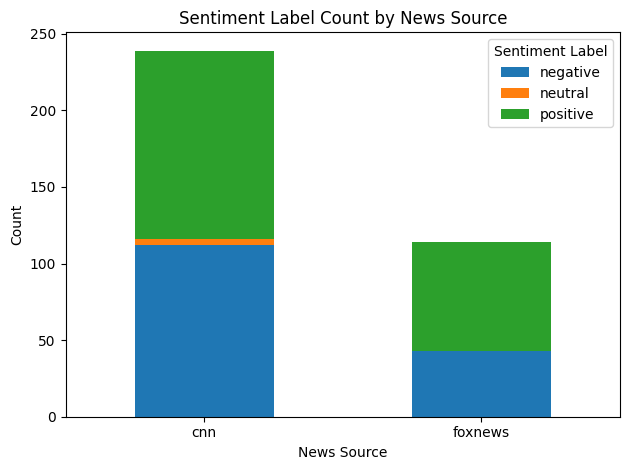

In [132]:
# Group by source and sentiment label and count occurrences
sentiment_counts = df.groupby(['source', 'sentiment_label']).size().unstack(fill_value=0)

sentiment_counts.plot(kind='bar', stacked=True)
plt.title('Sentiment Label Count by News Source')
plt.xlabel('News Source')
plt.ylabel('Count')
plt.xticks(rotation=0)  
plt.legend(title='Sentiment Label')
plt.tight_layout() 
plt.show()

## Binary Classification - Source Prediction

## Predicting News Sources with Random Forest Classifier

In [133]:

# Define X and y
X = df['tokens']  
y = df['source']  

# Convert list of tokens into strings and remove stop words
X_str = X.apply(lambda x: ' '.join([token for token in x if token.lower() not in sw]))

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X_str)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9295774647887324
Classification Report:
              precision    recall  f1-score   support

         cnn       0.90      1.00      0.95        47
     foxnews       1.00      0.79      0.88        24

    accuracy                           0.93        71
   macro avg       0.95      0.90      0.92        71
weighted avg       0.94      0.93      0.93        71



In [134]:

feature_importances = model.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

top_n = 20 
print(f"Top {top_n} features and their importances:")
for feature, importance in sorted_feature_importances[:top_n]:
    print(f"Feature: {feature}, Importance: {importance}")

Top 20 features and their importances:
Feature: the, Importance: 0.01849894312852414
Feature: bidens, Importance: 0.016272064396904328
Feature: feb, Importance: 0.012872621491500511
Feature: dc, Importance: 0.00918940594513564
Feature: we, Importance: 0.008931433339478769
Feature: updates, Importance: 0.008027619968092724
Feature: likely, Importance: 0.006936965712404289
Feature: access, Importance: 0.0066080098139611335
Feature: it, Importance: 0.006039834731780436
Feature: capitol, Importance: 0.005550582124864041
Feature: 2024, Importance: 0.0050767350210323605
Feature: welcome, Importance: 0.0050012381091091955
Feature: happening, Importance: 0.004928826124443096
Feature: robert, Importance: 0.004908768834208561
Feature: hands, Importance: 0.004695552874422576
Feature: articles, Importance: 0.004571382350202452
Feature: agreeing, Importance: 0.004456568595110799
Feature: videos, Importance: 0.00435909830070961
Feature: joined, Importance: 0.00431254260306297
Feature: held, Importan

## Clustering

Top words per cluster for CNN:
Cluster 0: democrat, suozzi, republican, election, senate, trump, biden, whatley, voter, pilip, 
Cluster 1: biden, hur, report, ukraine, house, president, us, intelligence, classified, austin, 
Cluster 2: trump, nato, haley, biden, us, southcarolina, voter, president, pierce, spending, 
Cluster 3: senate, border, bill, aid, mayorkas, republican, mcconnell, house, ukraine, assistance, 
Cluster 4: trump, case, trial, willis, court, supremecourt, election, newyork, hearing, judge, 


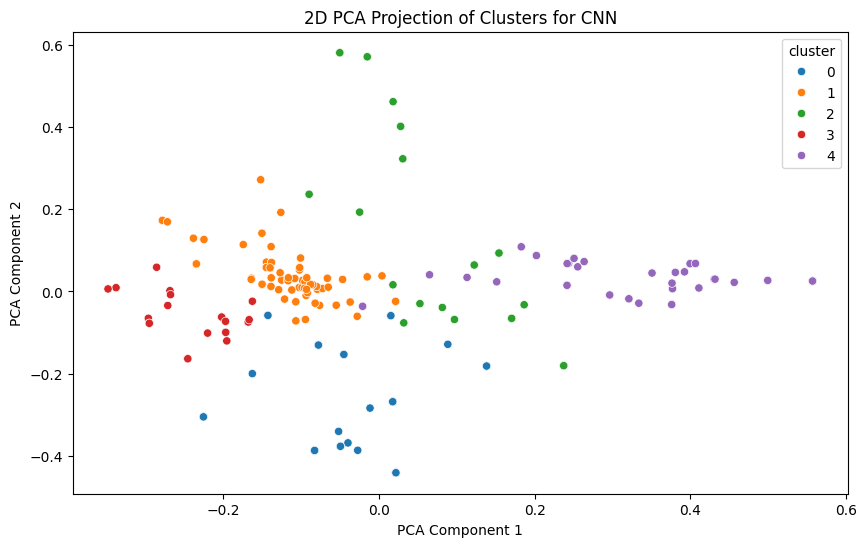

Top words per cluster for FoxNews:
Cluster 0: biden, special, hur, counsel, president, report, memory, classified, press, robert, 
Cluster 1: bobulinski, biden, hunterbiden, business, fbi, 2017, family, cefc, smirnov, energy, 
Cluster 2: trump, aid, nato, ukraine, package, bill, foreign, memo, billion, senate, 
Cluster 3: trump, willis, manchin, haley, romney, trial, judge, sen, court, running, 
Cluster 4: house, mayorkas, republican, security, border, senate, secretary, us, biden, vote, 


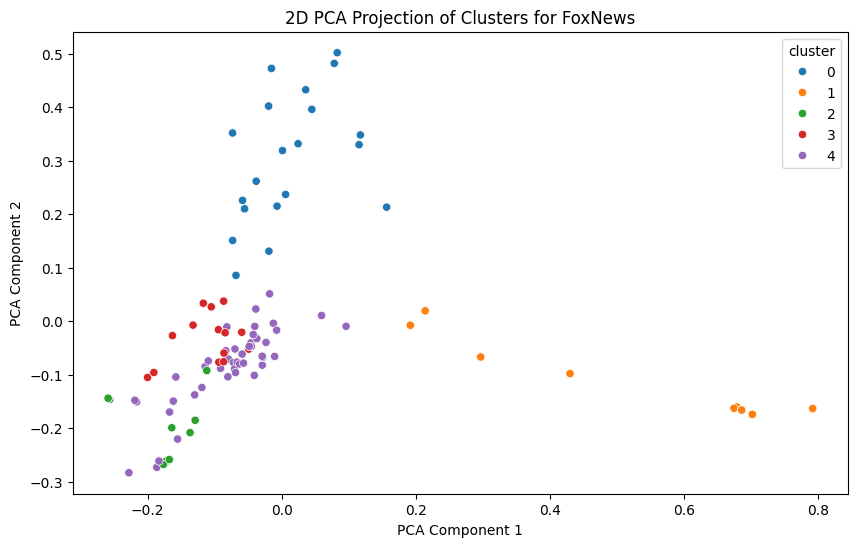

In [135]:

def cluster_and_plot(df, source_name):

    df['text'] = df['tokens'].apply(lambda x: ' '.join(x))
    tfidf_vectorizer = TfidfVectorizer()
    X_tfidf = tfidf_vectorizer.fit_transform(df['text'])

    # K-means clustering
    k = 5
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_tfidf)
    df['cluster'] = clusters

    # Print the top words per cluster
    print(f"Top words per cluster for {source_name}:")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    for i in range(k):
        print(f"Cluster {i}: ", end='')
        for ind in order_centroids[i, :10]:
            print(f'{terms[ind]}', end=', ')
        print()

    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_tfidf.toarray())

    # Add PCA components to DataFrame
    df['pca1'] = X_pca[:, 0]
    df['pca2'] = X_pca[:, 1]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='tab10', legend='full')
    plt.title(f'2D PCA Projection of Clusters for {source_name}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# CNN articles
df_cnn = df[df['source'] == 'cnn']
cluster_and_plot(df_cnn, 'CNN')

# FoxNews articles
df_fox = df[df['source'] == 'foxnews']
cluster_and_plot(df_fox, 'FoxNews')
